In [41]:
import streamlit as st
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
import holidays
from datetime import datetime
from funciones_LSTM import *
import warnings
warnings.filterwarnings('ignore')
import io
import sys

# Cargar el modelo previamente entrenado
modelo = load("model_app_1.joblib")
scaler_X = load('scaler_X.joblib')
scaler_Y = load('scaler_Y.joblib')

# Definir una función para redirigir la salida estándar
def suppress_stdout():
    sys.stdout = io.StringIO()

# Definir una función para restaurar la salida estándar
def restore_stdout():
    sys.stdout = sys.__stdout__

def predecir_demanda():
    cantidad_dias = 7
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": 40.71427,
        "longitude": -74.00597,
        "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall"],
        "timezone": "America/New_York",
        "past_days": 1,
        "forecast_days": cantidad_dias
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_rain = hourly.Variables(2).ValuesAsNumpy()
    hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["rain"] = hourly_rain
    hourly_data["snowfall"] = hourly_snowfall

    df = pd.DataFrame(data = hourly_data)
    df['fecha'] = df['date'].dt.date
    df['año'] = df['date'].dt.year
    df['mes'] = df['date'].dt.month
    df['dia'] = df['date'].dt.day
    df['hora'] = df['date'].dt.hour
    df['dia_semana'] = df['date'].dt.weekday + 1
    year = 2024
    us_holidays = holidays.US(years=year)
    us_holidays
    df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)

    hora_actual = datetime.now().time()
    fecha_actual = datetime.now().date()
    hora = hora_actual.hour
    dia = fecha_actual.day
    mes = fecha_actual.month
    anio = fecha_actual.year
    indice = df.loc[(df['año'] == anio) & (df['mes'] == mes) & (df['dia'] == dia) & (df['hora'] == hora)].index[0]
    df = df.loc[indice-4:,:]
    
    columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
    X = df[columnas_X]
    X = X.reset_index(drop=True)
    X_scaled = scaler_X.transform(X)
    X_reshaped = generador_X(X_scaled, p=5)

    columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

    suppress_stdout()
    Y_predict = modelo.predict(X_reshaped)
    restore_stdout()
    Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)

    prediccion = pd.concat([X[['año', 'mes', 'dia', 'hora']].loc[4:,:].reset_index(drop=True), Y_predict_original_df], axis=1)
    prediccion.dropna(inplace=True)
    prediccion = prediccion.astype(str)
    return prediccion

# Configuración de la página
st.title("Predicción de Demanda")
columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
# Botón para predecir la demanda
if st.button("Predecir demanda"):
    demanda_predicha = predecir_demanda()
    # Mostrar la tabla con las demandas predichas
    st.subheader("Demanda Predicha")
    st.table(demanda_predicha.round().astype(int))
    
    # Mostrar gráficos u otros visualizaciones
    st.subheader("Gráficos")
    # Aquí puedes agregar código para graficar los resultados, por ejemplo:
    for i in columnas_Y:
        sns.lineplot(x=demanda_predicha.index, y=demanda_predicha[i], label='Predicción')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    st.pyplot()



In [16]:
pd.set_option('display.max_rows', None)

In [42]:
demanda_predicha = predecir_demanda()
demanda_predicha

,año,mes,dia,hora,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,2024,4,12,19,61.365143,10.545362,41333.055,7019.105,4.857618
1,2024,4,12,20,59.683952,13.054642,41964.816,7094.6914,5.2710223
2,2024,4,12,21,58.914886,14.525323,42507.312,7183.1665,5.5348244
3,2024,4,12,22,57.600365,13.790201,42040.562,7132.4077,5.644619
4,2024,4,12,23,56.928158,11.992407,41583.06,7081.1025,5.675047
5,2024,4,13,0,51.432343,0.0,37111.914,6568.531,4.6365128
6,2024,4,13,1,48.186016,0.0,32732.941,5932.4946,3.5287497
7,2024,4,13,2,46.440487,0.0,28951.191,5302.058,2.6315079
8,2024,4,13,3,45.755997,0.0,25879.23,4754.684,2.0138834
9,2024,4,13,4,45.6781,3.5559351,23703.438,4339.999,1.6423811


In [40]:
demanda_predicha.dtypes

año                int32
mes                int32
dia                int32
hora               int32
Bronx            float32
Brooklyn         float32
Manhattan        float32
Queens           float32
Staten Island    float32
dtype: object

5/5 [==============================] - 0s 1ms/step


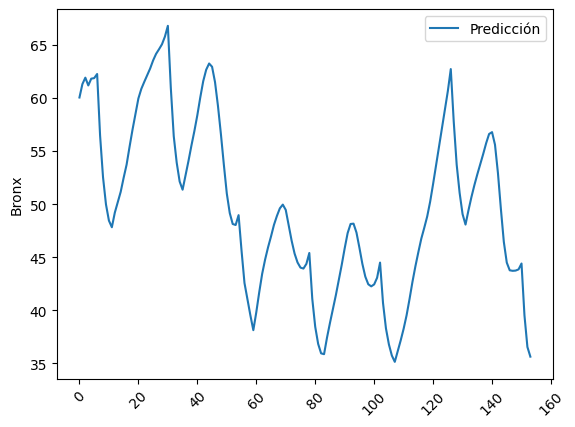

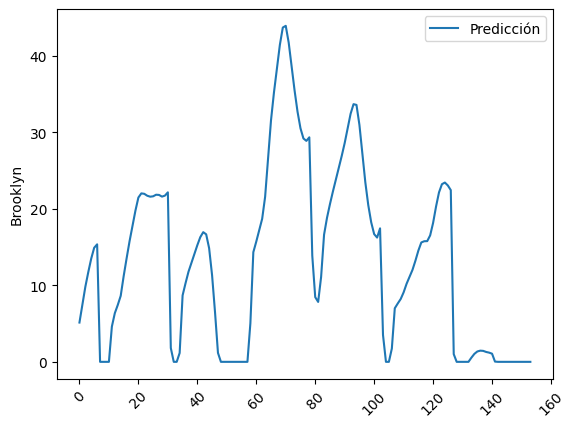

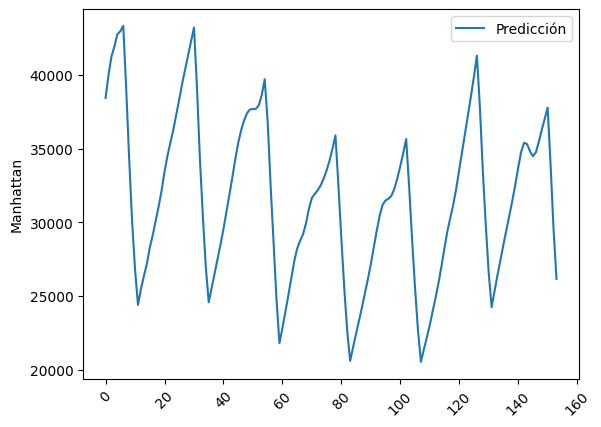

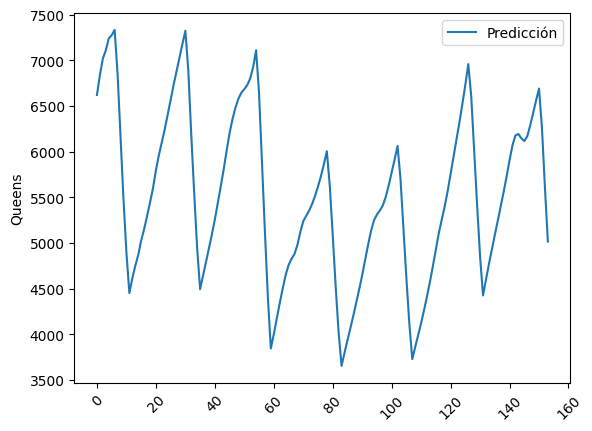

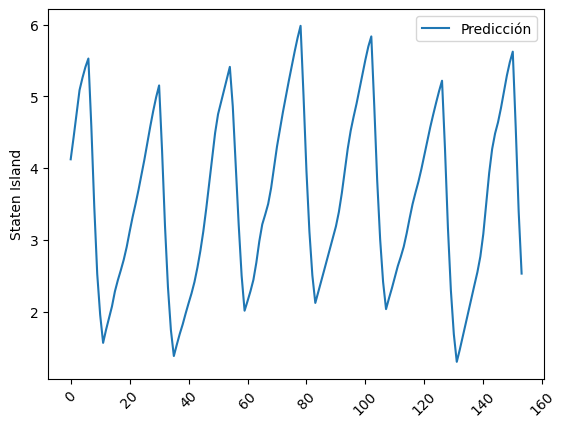

DeltaGenerator()

<Figure size 640x480 with 0 Axes>

In [5]:


for i in columnas_Y:
    sns.lineplot(x=demanda_predicha.index, y=demanda_predicha[i], label='Predicción')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
st.pyplot()